# Pessimistic Beliefsan and Accumulation of Assets

Here I am going to compute and plot the average asset accumulation for different values of the interest rate.
<br\>
I will look at four different cases:
<br\>
<br\>
* non-pessimistic case
* pessimistic case
* pessimistic case with a mean-preserving-spread with higher variance
* pessimistic case with a mean-preserving state-space and same variance

I will use a simple aiyagari model, where I am going to shock the interest rate and the wage by markov chains.

In [34]:
# First, I will write a function that returns a belief 
# decompostition of a transition matrix, a real transition 
# matrix and a corresponding belief matrix with pessimistic beliefs.

import numpy as np
from quantecon import MarkovChain

def trans_mat(P1, P3, epsilon):
    """
    Returns a transition matrix (for a markov chain) of the following form:
        
        Π = ((P1, P2, 0), (P2 - epsilon, P1, epsilon), (P4, P4, P3))
    
    where P2 = 1-P1 and P4 = 0.5*(1-P3)
    
    epsilon is the probability for the transition from the 2. to the 
    3. state.
    P1 is the probability to stay in the current state if the 
    current state is the 1. or 2. state.
    P3 ist the probability to stay in the 3rd state.
    2*P4 ist the probability to get out of the 3rd state.
    """
    P2, P4 = (1-P1), 0.5*(1-P3)
    
    Π = ((P1, P2, 0), (P2 - epsilon, P1, epsilon), (P4, P4, P3))
    
    return np.asarray(Π)


def belief_decompose(Π, z_vals):
    
    """
    Belief decomposition for a 3x3 matrix with the follwowing form:
        
        Π = ((P1, P2, 0), (P2 - epsilon, P1, epsilon), (P4, P4, P3))
        
    The belief matrix is pessimistic and has the following form:
        
        Π_belief = (( P1, 0.5*P2, 0.5*P2, 0), 
                    (0.5*(P2-epsilon), P1, 0.5*(P2-epsilon), epsilon), 
                    ( 0, 0, P1, 1 - P1), 
                    (P4, P4, 0, P3))
    """
    
    P1, P2, P3, P4 = Π[0][0], Π[0][1], Π[2][2], Π[2][0]
    epsilon = Π[1][2]
    
    Π_belief = (( P1, 0.5*P2, 0.5*P2, 0), 
                (0.5*(P2-epsilon), P1, 0.5*(P2-epsilon), epsilon), 
                ( 0, 0, P1, 1 - P1), 
                (P4, P4, 0, P3))
        
    # rewrite the real transition matrix
    Π_real = ((P1, 0.5*P2, 0.5*P2, 0),
              (P2-epsilon, 0.5*P1, 0.5*P1, epsilon), 
              (P2-epsilon, 0.5*P1, 0.5*P1, epsilon), 
              (P4, 0.5*P4, 0.5*P4, P3))
    
    # adjust state space
    z_vals = np.asarray(z_vals)
    z_vals = np.insert(z_vals, 1, z_vals[1])
    
    return np.asarray(Π_real), np.asarray(Π_belief), np.asarray(z_vals)

# write code with which you can compute a mean-preserving-spread
# for the 'perceived' state space

def exp_val(z_vals, P_z):
    """
    This function gives you the weighted average of all states of a 
    markov chain in the long run.
    
    Parameters
    -----------
    
    z_vals : state values of the markov chain
    P_z : transition matrix
    """
    mc = MarkovChain(P_z, state_values = z_vals) # get the stationary probs
    return np.sum(mc.stationary_distributions * z_vals) # compute weighted average

def mean_preserving_states(z_vals, Π_real, Π_belief, err_tol):
    exp_real = exp_val(z_vals=z_vals, P_z=Π_real)
    exp_belief = exp_val(z_vals=z_vals, P_z=Π_belief)
    z_vals_new = np.array(z_vals)
    diff = exp_real - exp_belief
    n = len(z_vals)
    
    s_dist = MarkovChain(Π_belief).stationary_distributions[0]
    w_high = s_dist[0]/(s_dist[0]+s_dist[-1]) #weight for high value state
    w_neg = 1 - w_high # weight for negative value state
    
    while abs(diff) > err_tol:
        if z_vals_new[-1] >= -0.3:
            z_vals_new[-1] = -0.3
            z_vals_new[0] = z_vals_new[0]+(w_high*diff)
            exp_real = exp_val(z_vals=z_vals, P_z=Π_real)
            exp_belief = exp_val(z_vals=z_vals_new, P_z=Π_belief)
            diff = exp_real - exp_belief
        else:
            z_vals_new[0], z_vals_new[-1] = z_vals_new[0]+(w_high*diff), z_vals_new[-1]+(w_neg*diff)
            exp_real = exp_val(z_vals=z_vals, P_z=Π_real)
            exp_belief = exp_val(z_vals=z_vals_new, P_z=Π_belief)
            diff = exp_real - exp_belief
            #print('{}, {}'.format(exp_real, exp_belief))
    return np.asarray(z_vals_new)

# write a function which return mean preserving states 
# without changing the variance:

def mean_and_var_preserving_states(z_vals, Π_real, Π_belief, err_tol, T=1000000):
    exp_real = exp_val(z_vals=z_vals, P_z=Π_real)
    exp_belief = exp_val(z_vals=z_vals, P_z=Π_belief)
    z_vals_new = np.array(z_vals)
    diff_exp = exp_real - exp_belief
    weights_exp = MarkovChain(Π_belief).stationary_distributions[0]
    weights_exp[2] = weights_exp[1]
    weights_exp = weights_exp/sum(weights_exp)
    n = len(z_vals)
    
    var_real = np.sqrt(np.var(MarkovChain(Π_real, z_vals).simulate(T)))
    var_belief = np.sqrt(np.var(MarkovChain(Π_belief, z_vals).simulate(T)))
    weights_var = MarkovChain(Π_belief).stationary_distributions[0][0:3]
    weights_var[2] = weights_var[1]
    weights_var = weights_var/sum(weights_var)
    diff_var = var_belief - var_real
    
    while abs(diff_exp) > err_tol or abs(diff_var) > err_tol:
    
        while abs(diff_exp) > err_tol:
            for i, weight in enumerate(weights_exp):
                z_vals_new[i] += weight*diff_exp
        
            exp_real = exp_val(z_vals=z_vals, P_z=Π_real)
            exp_belief = exp_val(z_vals=z_vals_new, P_z=Π_belief)
            diff_exp = exp_real - exp_belief
        
            var_real = np.sqrt(np.var(MarkovChain(Π_real, z_vals).simulate(T)))
            var_belief = np.sqrt(np.var(MarkovChain(Π_belief, z_vals_new).simulate(T)))
            diff_var = var_belief - var_real
    
        while abs(diff_var) > err_tol:
            for i, weight in enumerate(weights_var):
                if i == 0:
                    z_vals_new[i] -= weight*diff_var
                else:
                    z_vals_new[i] += weight*diff_var
                
            exp_real = exp_val(z_vals=z_vals, P_z=Π_real)
            exp_belief = exp_val(z_vals=z_vals_new, P_z=Π_belief)
            diff_exp = exp_real - exp_belief
        
            var_real = np.sqrt(np.var(MarkovChain(Π_real, z_vals).simulate(T)))
            var_belief = np.sqrt(np.var(MarkovChain(Π_belief, z_vals_new).simulate(T)))
            diff_var = var_belief - var_real
        
    #print('means_err: {}'.format(diff_exp))
    #print('variance_err: {}'.format(diff_var))
    #print('r-shock state values: {}'.format(np.asarray(z_vals_new)))
    
    return np.asarray(z_vals_new)


In [35]:
# Then, I will write a class and corresponding functions, 
# which distinguish between the two different 
# kinds of transition matrices.

import numpy as np
from scipy.optimize import brentq
from quantecon import MarkovChain

class Pair:
    """
    This class, takes two independent markov processes, 
    combines their state spaces
    and gives the corresponding transition matrix.
    """    
    
    def __init__(self,
                 a_vals = [0, 1], # state values of the first mc
                 b_vals = [1, 0], # state values of the second mc
                 P_a = [[0.9, 0.1], [0.1, 0.9]],
                 P_b = [[0.8, 0.2], [0.2, 0.8]]):
        
        self.a_vals = np.asarray(a_vals)
        self.b_vals = np.asarray(b_vals)
        self.P_a = np.asarray(P_a)
        self.P_b = np.asarray(P_b)
        self.n = len(a_vals) * len(b_vals)
        
        # Build the array with combined state values
        self.s_vals = make_statespace(self.a_vals, self.b_vals)
        
        # Combine both transition matrices
        self.Q = np.kron(self.P_b, self.P_a)
    

def make_statespace(a, b):
    """
    returns state space s_vals, when two statespaces of two independend markov 
    chains a, b are combined to s:=(a_state, b_state)
    
    Parameters
    ----------
    a,b : state spaces in form of numpy arrays containing the state values of
          the two markov chains a and b.
          
    Returns
    ---------
    state space vector : Returns a two-dimentional array 
                         [[a_state1, b_state1], [a_state2, b_state1], ...etc]
    """
    
    s_vals = []

    for j in range(len(b)):
        for i in range(len(a)):
            s_vals.append([a[i], b[j]])
    return np.array(s_vals)

def fixed_point(K, c_init, err_tol=1e-3, max_iter=300):
    i, c = 0, K(c_init)
    if np.linalg.norm((c-c_init))<err_tol:
        return c
    while max_iter>i and np.linalg.norm((c-c_init))>=err_tol:
        i=i+1
        c_init=c
        c=K(c_init)
    return np.asarray(c)

class canersHousehold:
    
    def __init__(self, 
                 r=0.03,
                 w=1,
                 β=0.96, 
                 Π_w=((0.6, 0.4), (0.05, 0.95)),
                 Π_r_real=((0.6, 0.4, 0), (0.35, 0.6, 0.05), (0.35, 0.35, 0.3)),
                 Π_r_belief=((0.6, 0.4, 0), (0.3, 0.6, 0.1), (0.35, 0.35, 0.3)),
                 z_w_vals=(0.5, 1.0),
                 z_r_vals=(1.5, 0.2, -0.5),
                 b=0, 
                 grid_max=16, 
                 grid_size=50,
                 du=lambda x: 1/x,
                 mean_preserved = False, 
                 mean_and_var_preserved = False):
        
        # simplify names, set up array and change the input
        # in a way so that you can adjust the coleman operator
        # and the simulation of assets, 
        # belief trans. matrix -> in coleman operator
        
        self.du, self.w, self.r = du, w, r
        self.grid_max, self.grid_size = grid_max, grid_size
        self.Π_w, self.z_w_vals = Π_w, z_w_vals
        self.β, self.b = β, b
        self.asset_grid = np.linspace(-b, grid_max, grid_size)
        self.mean_preserved = mean_preserved
        self.mean_and_var_preserved = mean_and_var_preserved
        
        self.Π_r_belief = np.asarray(Π_r_belief) 
        
        self.Π_r_real = np.asarray(Π_r_real)
        
        self.z_r_vals = np.asarray(z_r_vals)
        
        # perceived values
        
        if mean_preserved: 
            self.z_r_vals_mps = mean_preserving_states(self.z_r_vals,
                                                       self.Π_r_real,
                                                       self.Π_r_belief,
                                                       1e-7)
        elif mean_and_var_preserved:
            self.z_r_vals_mps = mean_and_var_preserving_states(self.z_r_vals,
                                                               self.Π_r_real,
                                                               self.Π_r_belief,
                                                               1e-4)
        
        # take the new transition matrices and combine them with
        # the transition matrix for the wage shock in order
        # to get Π_belief, Π_real and z_vals
        
        if mean_preserved or mean_and_var_preserved:
            self.z_belief = Pair(a_vals=self.z_r_vals_mps, # use perceived values here
                                 b_vals=z_w_vals,
                                 P_a=self.Π_r_belief,
                                 P_b=Π_w)
        else:
            
            self.z_belief = Pair(a_vals=self.z_r_vals,
                                 b_vals=z_w_vals,
                                 P_a=self.Π_r_belief,
                                 P_b=Π_w)
        
        self.z_real = Pair(a_vals=self.z_r_vals,
                           b_vals=z_w_vals,
                           P_a=self.Π_r_real,
                           P_b=Π_w)
        
        # you need two different state spaces, one for the simulation of the 
        # markov chain which needs the real values and the other one
        # for the operator which needs the belief values
        
        self.z_vals, self.z_belief_vals = self.z_real.s_vals, self.z_belief.s_vals
        self.Π_belief, self.Π_real = self.z_belief.Q, self.z_real.Q


def belief_operator(c, cp):
    
    # === simplify names, set up arrays === #
    r, Π_belief, β, du, b, w = cp.r, cp.Π_belief, cp.β, cp.du, cp.b, cp.w
    asset_grid, z_belief_vals = cp.asset_grid, cp.z_belief_vals
    z_size = len(z_belief_vals)
    vals = np.empty(z_size)
    
    def cf(a):
        for i in range(z_size):
            vals[i] = np.interp(a, asset_grid, c[:,i])
        return vals
    
    Kc = np.empty(c.shape)
    for i_a, a in enumerate(asset_grid):
        for i_z, z in enumerate(z_belief_vals):
            z_r, z_w = z[0], z[1]
            def h(t):
                expectation = np.dot(du(cf((1+r*z_r) * a + w * z_w - t)), Π_belief[i_z,:])
                return du(t) - max((1+r*z_r) * β * expectation, du((1+r*z_r) * a + w * z_w + b))
            Kc[i_a, i_z] = brentq(h, 1e-8, (1+r*z_r) * a + w * z_w + b)
    return Kc

def initialize(cp):
    # === Simplify names, set up arrays === #
    r, b, w = cp.r, cp.b, cp.w
    asset_grid, z_vals = cp.asset_grid, cp.z_belief_vals
    shape = len(asset_grid), len(z_vals)
    c = np.empty(shape)
    
    for i_a, a in enumerate(asset_grid):
        for i_z, z in enumerate(z_vals):
                z_r, z_w = z[0], z[1]
                c_max = (1+r*z_r) * a + w * z_w + b
                c[i_a, i_z] = c_max
    return c

def pessimistic_asset_series(cp,
                             T=250000,
                             max_iter=150):
    """
    Simulates a time series of length T for assets, given optimal savings
    behavior and pessimistic Beliefs. Parameter cp is an instance of canersPessimist.
    """
    
    Π_real, z_vals, r, w = cp.Π_real, cp.z_vals, cp.r, cp.w
    mc = MarkovChain(Π_real)
    c_init = initialize(cp)
    K = lambda c: belief_operator(c, cp)
    c = fixed_point(K=K, c_init=c_init, max_iter=max_iter)
    cf = lambda a, i_z: np.interp(a, cp.asset_grid, c[:, i_z])
    a = np.zeros(T+1)
    a[0]=1e-5
    z_seq = mc.simulate(T)
    for t in range(T):
        i_z = z_seq[t]
        a[t+1] = (1+r*z_vals[i_z][0]) * a[t] + w * z_vals[i_z][1] - cf(a[t], i_z)
    return a

I will write a function which simulates an asset series for a given number of periods by using the function 'pessimistic_asset_series()' and takes the mean. Another function will take different grid point of the interest rate, apply the procedure described above for each grid point and store the asset means in an array.

In [36]:
def pessi_asset_mean(cp, T=250000, max_iter=150):
    
    asset_mean = np.mean(pessimistic_asset_series(cp, T=T, max_iter=max_iter))
    return asset_mean

def pessi_capital_to_r(cp, 
                       r_min=1e-8, 
                       r_max=0.04, 
                       grid_points=5, 
                       T=250000, 
                       plot=False, 
                       max_iter=150):
    
    β, du, b, w = cp.β, cp.du, cp.b, cp.w 
    grid_max, grid_size = cp.grid_max, cp.grid_size
    Π_w, Π_r_real, Π_r_belief = cp.Π_w, cp.Π_r_real, cp.Π_r_belief 
    z_w_vals, z_r_vals = cp.z_w_vals, cp.z_r_vals
    
    # check if there is mean-preserving-spread is 'True'
    
    mean_preserved = cp.mean_preserved
    mean_and_var_preserved = cp.mean_and_var_preserved
    
    r_vals = np.linspace(r_min, r_max, grid_points)
    asset_means = []
    
    for i, r_val in enumerate(r_vals):
        hh = canersHousehold(r=r_val,
                             w=w,
                             β=β,
                             Π_w=Π_w,
                             Π_r_real=Π_r_real,
                             Π_r_belief=Π_r_belief,
                             z_w_vals=z_w_vals,
                             z_r_vals=z_r_vals,
                             b=b,
                             grid_max=grid_max,
                             grid_size=grid_size,
                             du=du,
                             mean_preserved=mean_preserved, 
                             mean_and_var_preserved=mean_and_var_preserved)
        mean = pessi_asset_mean(hh, T=T, max_iter=max_iter)
        asset_means.append(mean)
        print('Finished iterating {:01.0f} %'.format(((i+1)/ grid_points)*100))

    if plot:
        fig, ax = plt.subplots(figsize=(10,8))
        ax.plot(np.asarray(asset_means), r_vals)
        ax.set_xlabel('capital')
        ax.set_ylabel('interest rate')
        ax.grid(True)
        plt.show()


    return np.asarray(asset_means)  

In [27]:
# Calibration
z_r_vals = (1.5, 0.2, -0.5)
z_w_vals = (0.5, 1)

# transition matrix for r-shock
P1, P3, epsilon = 0.6, 0.3, 0.005
p1 = 0.6
#Π_w = ((p1, 1-p1), (1-p1, p1))
Π_r_real, Π_r_belief, z_r_vals = belief_decompose(trans_mat(P1, P3, epsilon), z_r_vals)
Π_r_real, Π_r_belief, z_r_vals

(array([[ 0.6  ,  0.2  ,  0.2  ,  0.   ],
        [ 0.395,  0.3  ,  0.3  ,  0.005],
        [ 0.395,  0.3  ,  0.3  ,  0.005],
        [ 0.35 ,  0.175,  0.175,  0.3  ]]),
 array([[ 0.6   ,  0.2   ,  0.2   ,  0.    ],
        [ 0.1975,  0.6   ,  0.1975,  0.005 ],
        [ 0.    ,  0.    ,  0.6   ,  0.4   ],
        [ 0.35  ,  0.35  ,  0.    ,  0.3   ]]),
 array([ 1.5,  0.2,  0.2, -0.5]))

In [31]:
# create instances for different cases
# 1. non-pessimistic
hh1 = canersHousehold(z_r_vals=z_r_vals, 
                      z_w_vals=z_w_vals,  
                      Π_r_real=Π_r_real, 
                      Π_r_belief=Π_r_real)
# 2. pessimistic
hh2 = canersHousehold(z_r_vals=z_r_vals, 
                      z_w_vals=z_w_vals, 
                      Π_r_real=Π_r_real, 
                      Π_r_belief=Π_r_belief)
# 3. pessimistic with mean-preserving-spread
hh3 = canersHousehold(z_r_vals=z_r_vals, 
                      z_w_vals=z_w_vals,  
                      Π_r_real=Π_r_real, 
                      Π_r_belief=Π_r_belief, 
                      mean_preserved = True)
# 4. pessimistic with mean-preserving statespace and same variance
hh4 = canersHousehold(z_r_vals=z_r_vals, 
                      z_w_vals=z_w_vals,  
                      Π_r_real=Π_r_real, 
                      Π_r_belief=Π_r_belief, 
                      mean_and_var_preserved = True)

means_err: 2.129536095107909e-05
variance_err: 3.6763145805362996e-07
r-shock state values: [ 1.72055128  0.7293207   0.7293207  -0.2845934 ]


In [32]:
T=500000
M=25
r_min, r_max = 1e-6, 0.025
max_iter = 500

print('\n \n 1. non-pessimistic case: \n')
assets_hh1 = pessi_capital_to_r(hh1,
                                T=T, 
                                r_min=r_min, 
                                r_max=r_max, 
                                max_iter=max_iter, 
                                grid_points=M)

print('\n \n 2. pessimistic case: \n')
assets_hh2 = pessi_capital_to_r(hh2,
                                T=T, 
                                r_min=r_min, 
                                r_max=r_max, 
                                max_iter=max_iter, 
                                grid_points=M)

print('\n \n 3. pessimistic with mean-preserving-spread case: \n')
assets_hh3 = pessi_capital_to_r(hh3,
                                T=T, 
                                r_min=r_min, 
                                r_max=r_max, 
                                max_iter=max_iter, 
                                grid_points=M)

print('\n \n 4. pessimistic with mean-preserving statespace and same variance case: \n')
assets_hh4 = pessi_capital_to_r(hh4,
                                T=T, 
                                r_min=r_min, 
                                r_max=r_max, 
                                max_iter=max_iter, 
                                grid_points=M)


 
 1. non-pessimistic case: 

Finished iterating 4 %
Finished iterating 8 %
Finished iterating 12 %
Finished iterating 16 %
Finished iterating 20 %
Finished iterating 24 %
Finished iterating 28 %
Finished iterating 32 %
Finished iterating 36 %
Finished iterating 40 %
Finished iterating 44 %
Finished iterating 48 %
Finished iterating 52 %
Finished iterating 56 %
Finished iterating 60 %
Finished iterating 64 %
Finished iterating 68 %
Finished iterating 72 %
Finished iterating 76 %
Finished iterating 80 %
Finished iterating 84 %
Finished iterating 88 %
Finished iterating 92 %
Finished iterating 96 %
Finished iterating 100 %

 
 2. pessimistic case: 

Finished iterating 4 %
Finished iterating 8 %
Finished iterating 12 %
Finished iterating 16 %
Finished iterating 20 %
Finished iterating 24 %
Finished iterating 28 %
Finished iterating 32 %
Finished iterating 36 %
Finished iterating 40 %
Finished iterating 44 %
Finished iterating 48 %
Finished iterating 52 %
Finished iterating 56 %
Finished 

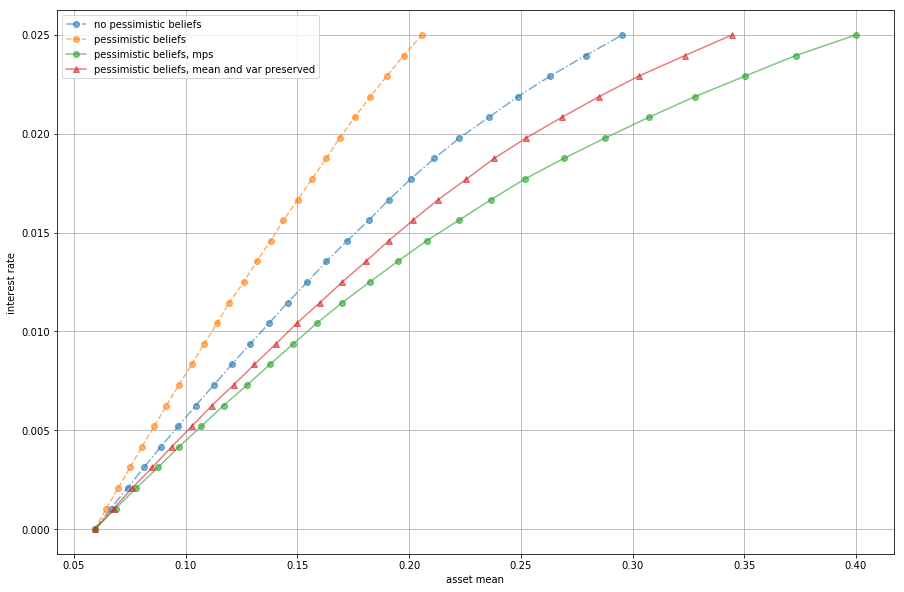

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(assets_hh1, np.linspace(r_min, r_max, M),'o-.', alpha=0.6, label='no pessimistic beliefs')
ax.plot(assets_hh2, np.linspace(r_min, r_max, M),'o--', alpha=0.6, label='pessimistic beliefs')
ax.plot(assets_hh3, np.linspace(r_min, r_max, M),'o-', alpha=0.6, label='pessimistic beliefs, mps')
ax.plot(assets_hh4, np.linspace(r_min, r_max, M),'^-', alpha=0.6, label='pessimistic beliefs, mean and var preserved')
#ax.set_yticks(np.arange(0, 0.04, .01))
#ax.set_xticks(np.arange(0, 0.5, 0.1))
#plt.ylim(0, 0.04)
#plt.xlim(0, 0.5)
ax.set_xlabel('asset mean')
ax.set_ylabel('interest rate')
ax.grid(True)
ax.legend(loc='upper left')

plt.show()